In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from torchvision.models import resnet50
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
# dataset stats
train_data_path = '/kaggle/input/us-license-plates-image-classification/new plates/train'
test_data_path = '/kaggle/input/us-license-plates-image-classification/new plates/test'
valid_data_path = '/kaggle/input/us-license-plates-image-classification/new plates/valid'

train_data_count = []
test_data_count = []
valid_data_count = []

class_name = os.listdir(train_data_path)
class_name.sort()

# train data stats
for i in class_name:
    train_data_count.append(len(os.listdir(train_data_path + '/' + i)))
    test_data_count.append(len(os.listdir(test_data_path + '/' + i)))
    valid_data_count.append(len(os.listdir(valid_data_path + '/' + i)))

# print dataset statistics in table format
print(f"{'Class Name':<20} {'Train Count':<12} {'Test Count':<12} {'Valid Count':<12}")
print("=" * 60)

train_total = test_total = valid_total = 0
for i in range(len(class_name)):
    train_total += train_data_count[i]
    test_total += test_data_count[i]
    valid_total += valid_data_count[i]
    print(f"{class_name[i]:<20} {train_data_count[i]:<12} {test_data_count[i]:<12} {valid_data_count[i]:<12}")

print("=" * 60)
print(f"{'TOTAL':<20} {train_total:<12} {test_total:<12} {valid_total:<12}")
    

Class Name           Train Count  Test Count   Valid Count 
ALABAMA              157          5            5           
ALASKA               149          5            5           
AMERICAN SAMOA       143          5            5           
ARIZONA              139          5            5           
ARKANSAS             169          5            5           
CALIFORNIA           154          5            5           
CNMI                 86           5            5           
COLORADO             133          5            5           
CONNECTICUT          143          5            5           
DELAWARE             141          5            5           
FLORIDA              149          5            5           
GEORGIA              136          5            5           
GUAM                 162          5            5           
HAWAI                144          5            5           
IDAHO                144          5            5           
ILLINOIS             144          5     

In [17]:
print(class_name)

data_path = '/kaggle/input/us-license-plates-image-classification/new plates'
csv_path = data_path + "/plates.csv"

df = pd.read_csv(csv_path)  # Read the CSV file into a pandas DataFrame
print(df.head())  # Print the first few rows

['ALABAMA', 'ALASKA', 'AMERICAN SAMOA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'CNMI', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'GUAM', 'HAWAI', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'PUERTO RICO', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'U S VIRGIN ISLANDS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WASHINGTON DC', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING']
   class id              filepaths   labels data set
0         0  train/ALABAMA/001.jpg  ALABAMA    train
1         0  train/ALABAMA/002.jpg  ALABAMA    train
2         0  train/ALABAMA/003.jpg  ALABAMA    train
3         0  train/ALABAMA/004.jpg  ALABAMA    train
4         0  train/ALABAMA/0

In [18]:
class CustomDataset(Dataset):
    # 0001.jpg, 0
    # 0001.jpg, [1,0,0,0,0,0,0, ...]
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # 1 hot encoding setup
        label_idx = self.labels[idx]
        label = torch.zeros(56)
        label[label_idx] = 1

        # Load the image
        image = Image.open('/kaggle/input/us-license-plates-image-classification/new plates/'+image_path)


        # Define transformations

        # approach 1: centercrop to 224x224 (losign left and right side of the image)
        transform = transforms.Compose([
            transforms.Resize(224),      # Resize the shorter side to 224 pixels
            transforms.CenterCrop(224),  # Crop the center to 224x224
            transforms.ToTensor()        # Convert to tensor
        ])

        # approach 2: stretch the image to fit 224x224 (does not lose any info)
        # transform = transforms.Compose([
        #     transforms.Resize((224,224)),      # Resize the shorter side to 224 pixels
        #     transforms.ToTensor()        # Convert to tensor
        # ])
    
        # Apply transformations
        tensor_image = transform(image)

        return tensor_image, label, image_path

In [19]:
df_train = df[df["data set"] == "train"][["filepaths", "class id"]]
train_data = CustomDataset(df_train["filepaths"], df_train["class id"])

df_test = df[df["data set"] == "test"][["filepaths", "class id"]].reset_index(drop=True)
test_data = CustomDataset(df_test["filepaths"], df_test["class id"])

df_valid = df[df["data set"] == "valid"][["filepaths", "class id"]].reset_index(drop=True)
valid_data = CustomDataset(df_valid["filepaths"], df_valid["class id"])

# print a sample image
print(train_data.__getitem__(0))
print(test_data.__getitem__(0))
print(valid_data.__getitem__(0))

dl_train = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory = True, num_workers=4)
dl_test = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory = True, num_workers=4)
dl_valid = DataLoader(valid_data, batch_size=1, shuffle=True, pin_memory = True, num_workers=4)

print(f'train images count: {len(train_data)}')
print(f'test images count: {len(test_data)}')
print(f'valid images count: {len(valid_data)}')

(tensor([[[0.7608, 0.7647, 0.7686,  ..., 0.6784, 0.6745, 0.6745],
         [0.7804, 0.7804, 0.7804,  ..., 0.6863, 0.6863, 0.6863],
         [0.8078, 0.8039, 0.8000,  ..., 0.6980, 0.7059, 0.7059],
         ...,
         [0.7882, 0.7843, 0.7765,  ..., 0.3647, 0.3804, 0.3843],
         [0.7098, 0.7059, 0.7020,  ..., 0.4745, 0.4784, 0.4824],
         [0.6588, 0.6588, 0.6549,  ..., 0.5451, 0.5412, 0.5451]],

        [[0.7333, 0.7373, 0.7412,  ..., 0.6667, 0.6627, 0.6627],
         [0.7529, 0.7529, 0.7529,  ..., 0.6706, 0.6706, 0.6706],
         [0.7804, 0.7765, 0.7725,  ..., 0.6784, 0.6863, 0.6863],
         ...,
         [0.7608, 0.7569, 0.7490,  ..., 0.3529, 0.3647, 0.3686],
         [0.6784, 0.6784, 0.6784,  ..., 0.4667, 0.4706, 0.4745],
         [0.6275, 0.6314, 0.6353,  ..., 0.5373, 0.5333, 0.5373]],

        [[0.6902, 0.6980, 0.7020,  ..., 0.5922, 0.5882, 0.5922],
         [0.7098, 0.7137, 0.7137,  ..., 0.5961, 0.6000, 0.6039],
         [0.7412, 0.7373, 0.7333,  ..., 0.6039, 0.6157, 0

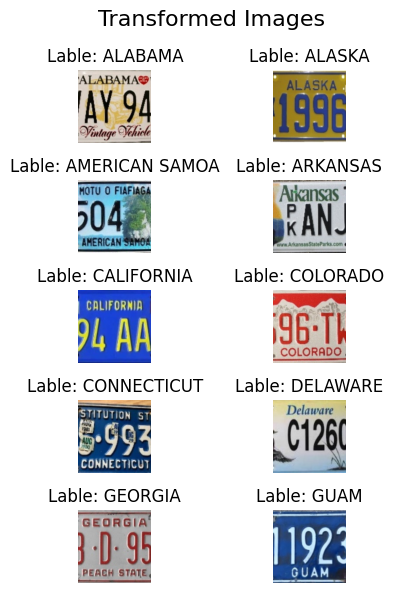

In [20]:
# Display transformed iamges
fig, axes = plt.subplots(5, 2, figsize=(5,6))

fig.suptitle("Transformed Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < 10:
        tensor_image, label, image_path = train_data.__getitem__(i*200)
        img = to_pil_image(tensor_image.squeeze(0))
        ax.imshow(img)
        ax.set_title(f"Lable: {class_name[label.argmax(dim=-1).item()]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device", device)

# initialize resnet50 model
model = resnet50()
model.fc = torch.nn.Linear(2048, 56)
model.to(device)

device cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(dataloader):
  # use tqdm for for loop
  progress = tqdm(dataloader)
  total_loss = 0
  total_correct = 0
  total_sample = 0

  for i, data in enumerate(progress):
    # extract data and label
    tensor_image, label, image_label = data

    # move data to the same device as the model
    tensor_image = tensor_image.to(device)
    label = label.to(device)

    # clear optimizer
    optimizer.zero_grad()

    # get the prediction from the current model
    output = model(tensor_image)

    # convert label from long to float (for BCE loss func)
    label = label.float()

    # calculate the loss
    loss = loss_fn(output, label)
    loss.backward()

    # update the weights of the model
    optimizer.step()

    # update total_loss value
    total_loss += loss.item()



    true_classes = label.argmax(dim=1)
    # compute accuracy for the batch
    predicted_classes = output.argmax(dim=1)
    batch_correct = (predicted_classes == true_classes).sum().item()
    total_correct += batch_correct
    total_sample += label.shape[0]

    # add description to progress bar
    progress.set_description(f"batch: {i+1} | loss:{loss.item()}")

  avg_loss = total_loss / len(dataloader)
  train_accuracy = total_correct * 100 / total_sample
  return avg_loss, train_accuracy  # Return average loss over all batches

In [23]:
def evaluate(dataloader):
    # use tqdm for for loop
    progress = tqdm(dataloader)
    total_loss = 0
    total_correct = 0
    total_sample = 0
    with torch.no_grad():
        for i, data in enumerate(progress):
            tensor_image, label, image_label = data
            # print(label.shape) # torch.Size([32, 56])
            
            # move data to the same device as the model
            tensor_image = tensor_image.to(device)
            label = label.to(device)

            output = model(tensor_image)
            true_classes = label.argmax(dim=1) 
            predicted_classes = output.argmax(dim=1) # shape: [32] w all max index
            # print(true_classes.shape, predicted_classes.shape) # torch.Size([32, 56])

            batch_correct = (predicted_classes == true_classes).sum().item()
            total_correct += batch_correct
            total_sample += label.shape[0]

            # Compute loss
            total_loss += loss_fn(output, label).item()

    avg_loss = total_loss / len(dl_test)
    accuracy = total_correct*100/total_sample
    # print(f"accuracy: {total_correct*100/total_sample}%")
    return avg_loss, accuracy


In [24]:
# training
EPOCHS = 25

avg_loss_log = []
train_accuracy_log = []
avg_test_loss_log = []
test_accuracy_log = []

best_test_avg_loss = float('inf')
best_model_path = "/kaggle/working/best_model.pth"

for epoch in range(EPOCHS):
    model.train()
    print("EPOCH:", epoch)
    avg_loss, train_accuracy = train_one_epoch(dl_train)
    print("avg loss:", avg_loss)
    avg_loss_log.append(avg_loss)
    train_accuracy_log.append(train_accuracy)

    model.eval()
    test_avg_loss, test_accuracy = evaluate(dl_test)
    print(f"avg test loss: {test_avg_loss}")
    print(f"accuracy: {test_accuracy}%")
    
    avg_test_loss_log.append(test_avg_loss)
    test_accuracy_log.append(test_accuracy)

    if test_avg_loss < best_test_avg_loss:
        best_test_avg_loss = test_avg_loss
        torch.save(model.state_dict(), best_model_path)
    
    print()

EPOCH: 0


batch: 256 | loss:0.1082616001367569: 100%|██████████| 256/256 [00:45<00:00,  5.69it/s] 


avg loss: 0.09653047416941263


100%|██████████| 9/9 [00:00<00:00, 10.67it/s]


avg test loss: 0.09114487220843633
accuracy: 5.357142857142857%

EPOCH: 1


batch: 256 | loss:0.1206095814704895: 100%|██████████| 256/256 [00:43<00:00,  5.87it/s] 


avg loss: 0.08632715922431089


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


avg test loss: 0.09517073051797019
accuracy: 10.714285714285714%

EPOCH: 2


batch: 256 | loss:0.152442067861557: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s]  


avg loss: 0.08138196863001212


100%|██████████| 9/9 [00:00<00:00, 11.51it/s]


avg test loss: 0.24237095399035347
accuracy: 13.928571428571429%

EPOCH: 3


batch: 256 | loss:0.21963779628276825: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s] 


avg loss: 0.0748241398105165


100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


avg test loss: 0.15388683560821745
accuracy: 9.642857142857142%

EPOCH: 4


batch: 256 | loss:0.133831188082695: 100%|██████████| 256/256 [00:43<00:00,  5.87it/s]   


avg loss: 0.0732232372101862


100%|██████████| 9/9 [00:00<00:00, 11.61it/s]


avg test loss: 0.07269338683949576
accuracy: 26.785714285714285%

EPOCH: 5


batch: 256 | loss:0.11294997483491898: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s] 


avg loss: 0.06452519015874714


100%|██████████| 9/9 [00:00<00:00, 11.67it/s]


avg test loss: 0.07450067748626073
accuracy: 25.357142857142858%

EPOCH: 6


batch: 256 | loss:0.11061860620975494: 100%|██████████| 256/256 [00:43<00:00,  5.87it/s] 


avg loss: 0.05879284148977604


100%|██████████| 9/9 [00:00<00:00, 11.82it/s]


avg test loss: 0.06833834366665946
accuracy: 30.714285714285715%

EPOCH: 7


batch: 256 | loss:0.15166041254997253: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s] 


avg loss: 0.053881454339716583


100%|██████████| 9/9 [00:00<00:00, 11.89it/s]


avg test loss: 0.08043469819757673
accuracy: 32.5%

EPOCH: 8


batch: 256 | loss:0.11989262700080872: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s] 


avg loss: 0.04982360784924822


100%|██████████| 9/9 [00:00<00:00, 12.03it/s]


avg test loss: 0.056543937573830284
accuracy: 47.857142857142854%

EPOCH: 9


batch: 256 | loss:0.1708589345216751: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s]  


avg loss: 0.044720939673425164


100%|██████████| 9/9 [00:00<00:00, 12.14it/s]


avg test loss: 0.053007785230875015
accuracy: 50.0%

EPOCH: 10


batch: 256 | loss:0.17618033289909363: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.04054151001764694


100%|██████████| 9/9 [00:00<00:00, 11.87it/s]


avg test loss: 0.059279305239518486
accuracy: 56.07142857142857%

EPOCH: 11


batch: 256 | loss:0.15259268879890442: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.036637430981500074


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


avg test loss: 0.04796790124641524
accuracy: 56.785714285714285%

EPOCH: 12


batch: 256 | loss:0.17133358120918274: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.031703650529379956


100%|██████████| 9/9 [00:00<00:00, 11.82it/s]


avg test loss: 0.051669235858652324
accuracy: 60.0%

EPOCH: 13


batch: 256 | loss:0.22386610507965088: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.027404030341131147


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


avg test loss: 0.08830251503321859
accuracy: 60.0%

EPOCH: 14


batch: 256 | loss:0.15182779729366302: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.024124883304466493


100%|██████████| 9/9 [00:00<00:00, 12.10it/s]


avg test loss: 0.049481377419498235
accuracy: 62.142857142857146%

EPOCH: 15


batch: 256 | loss:0.2072063833475113: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]  


avg loss: 0.020038814240251668


100%|██████████| 9/9 [00:00<00:00, 12.18it/s]


avg test loss: 0.038243785293565855
accuracy: 66.07142857142857%

EPOCH: 16


batch: 256 | loss:0.21645498275756836: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s] 


avg loss: 0.016545218790270155


100%|██████████| 9/9 [00:00<00:00, 10.74it/s]


avg test loss: 0.0995358909583754
accuracy: 65.0%

EPOCH: 17


batch: 256 | loss:0.22506144642829895: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]  


avg loss: 0.013837079637596617


100%|██████████| 9/9 [00:00<00:00, 11.94it/s]


avg test loss: 0.08193136441210906
accuracy: 70.35714285714286%

EPOCH: 18


batch: 256 | loss:0.3098126947879791: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]  


avg loss: 0.012377576256767497


100%|██████████| 9/9 [00:00<00:00, 11.98it/s]


avg test loss: 0.04886128422286776
accuracy: 62.857142857142854%

EPOCH: 19


batch: 256 | loss:0.21058300137519836: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]  


avg loss: 0.017229898079676786


100%|██████████| 9/9 [00:00<00:00, 11.50it/s]


avg test loss: 0.03418384233696593
accuracy: 76.42857142857143%

EPOCH: 20


batch: 256 | loss:0.22711578011512756: 100%|██████████| 256/256 [00:43<00:00,  5.86it/s]  


avg loss: 0.008771280151904648


100%|██████████| 9/9 [00:00<00:00, 11.90it/s]


avg test loss: 0.036951076032386884
accuracy: 75.35714285714286%

EPOCH: 21


batch: 256 | loss:0.306443452835083: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s]    


avg loss: 0.007089404834005109


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


avg test loss: 0.0334619153290987
accuracy: 78.21428571428571%

EPOCH: 22


batch: 256 | loss:0.2743617296218872: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s]   


avg loss: 0.008557322404612933


100%|██████████| 9/9 [00:00<00:00, 11.69it/s]


avg test loss: 0.03197780458463563
accuracy: 77.5%

EPOCH: 23


batch: 256 | loss:0.3008824586868286: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]   


avg loss: 0.005419590010887987


100%|██████████| 9/9 [00:00<00:00, 11.30it/s]


avg test loss: 0.032649905110398926
accuracy: 77.85714285714286%

EPOCH: 24


batch: 256 | loss:0.295585036277771: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s]    


avg loss: 0.004431539789038652


100%|██████████| 9/9 [00:00<00:00, 11.47it/s]

avg test loss: 0.03584157096015082
accuracy: 77.5%



In [25]:
torch.save(model.state_dict(), best_model_path)

<ipython-input-26-eb73cdb7466c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


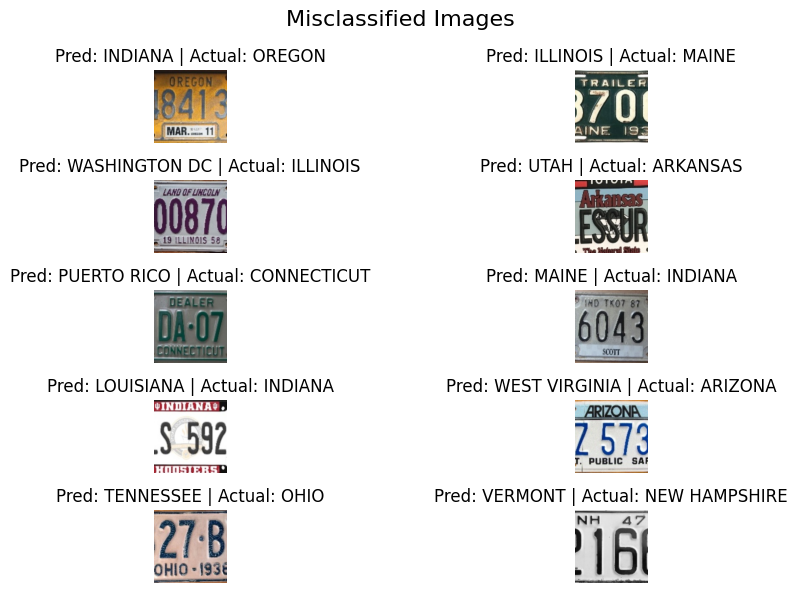

In [26]:
# see model's performance with validate datas
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

misclassified_images = []
misclassified_labels = []
misclassified_preds = []
misclassified_paths = []

with torch.no_grad():
    for data in dl_valid:
        tensor_image, label, image_path = data
        tensor_image = tensor_image.to(device)
        label = label.to(device)

        output = model(tensor_image)
        
        true_class = label.argmax(dim=1) 
        predicted_class = output.argmax(dim=1)

        if predicted_class != true_class: # wrong prediction
            misclassified_images.append(tensor_image.cpu())
            misclassified_labels.append(true_class.item())
            misclassified_preds.append(predicted_class.item())
            misclassified_paths.append(image_path[0])
# Display misclassified images
num_display = min(10, len(misclassified_images))  # Display up to 10 images
fig, axes = plt.subplots(5, 2, figsize=(12, 6))  # Create 2x5 grid

fig.suptitle("Misclassified Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < num_display:
        img = to_pil_image(misclassified_images[i].squeeze(0))  # Convert tensor to image
        ax.imshow(img)
        ax.set_title(f"Pred: {class_name[misclassified_preds[i]]} | Actual: {class_name[misclassified_labels[i]]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

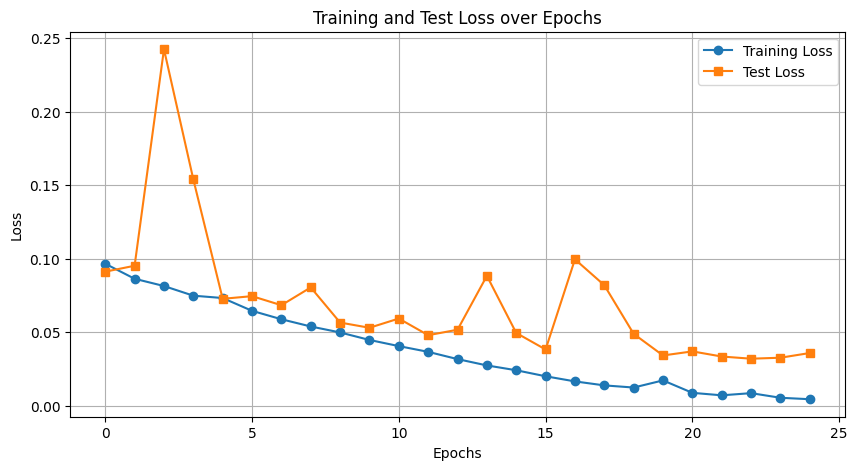

In [27]:
# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(avg_loss_log, label='Training Loss', marker='o')
plt.plot(avg_test_loss_log, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

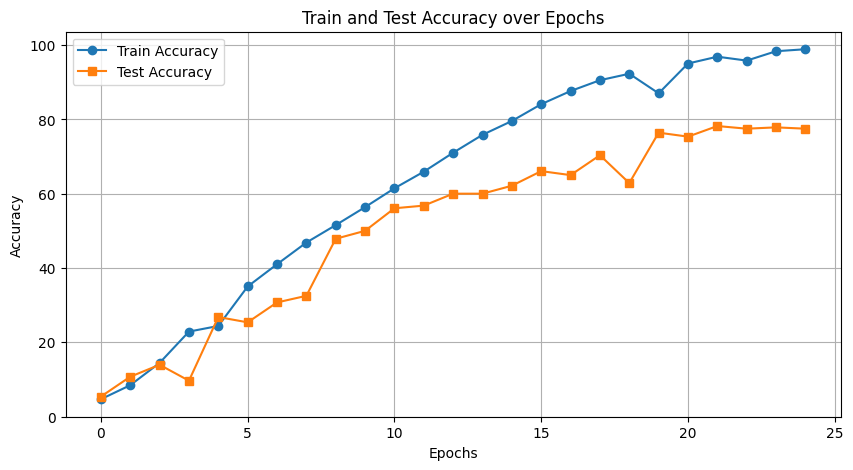

In [28]:
# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_log, label='Train Accuracy', marker='o')
plt.plot(test_accuracy_log, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()